# <center> Categorical encoders
### <center> With [Scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features ) and [Category Encoders](https://contrib.scikit-learn.org/category_encoders/)
    
**This is a notebook from [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course. You can reference the tutorial at [this link](https://www.kaggle.com/matleonard/categorical-encodings).**

## Imports

In [3]:
import numpy as np
import pandas as pd
import category_encoders as ce

import lightgbm as lgb
import sklearn as skl
from sklearn import impute
from sklearn import pipeline
from sklearn import compose
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)
print("lightgbm", lgb.__version__)
print("Cat Enc.", ce.__version__)

Pandas   1.2.4
Sklearn  0.24.2
lightgbm 3.2.1
Cat Enc. 2.2.2


### Load data

In [4]:
!ls ../../Datasets/Tabular/kickstarter-projects

ls: cannot access '../../Datasets/Tabular/kickstarter-projects': No such file or directory


In [6]:
path = "../../Datasets/Tabular/kickstarter-projects/"
df   = pd.read_csv(path+'ks-projects-201801.csv',
                   #index_col="ID",
                   parse_dates=['deadline', 'launched'])

# Drop live projects
df = df.query('state != "live"')

# Timestamp features
df = df.assign(hour = df.launched.dt.hour,
               day  = df.launched.dt.day,
               month= df.launched.dt.month,
               year = df.launched.dt.year)

# Add target column, "successful" == 1, others are 0
df["target"] = (df['state'] == 'successful').astype(int)

df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,hour,day,month,year,target
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,12,11,8,2015,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,4,2,9,2017,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,12,1,2013,0


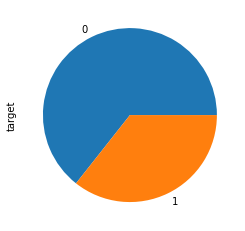

In [7]:
df.target.value_counts().plot.pie();

## Select data

In [8]:
cat_vars = ['category', 'currency', 'country']
num_vars = ['goal', 'hour', 'day', 'month', 'year']

x = df[cat_vars + num_vars]
y = df["target"] # "successful" == 1, others are 0

## Prepro

In [9]:
cat_encoders = {
    "OneHot":      ce.OneHotEncoder(cols = cat_vars),
    "Ordinal":     ce.OrdinalEncoder(cols = cat_vars),
    "Binary":      ce.BinaryEncoder(cols = cat_vars),
    "Count":       ce.CountEncoder(cols = cat_vars, min_group_size=False),
    "Frequency":   ce.CountEncoder(cols = cat_vars, min_group_size=False, normalize=True),
    "Target":      ce.TargetEncoder(cols = cat_vars),
    "Target_LOO":  ce.LeaveOneOutEncoder(cols = cat_vars),
    "Target_CatB": ce.TargetEncoder(cols = cat_vars),
}

# OTHERS LESS COMMON CAT ENCODERS
#
# ce.BackwardDifferenceEncoder()
# ce.BaseNEncoder()
# ce.GLMMEncoder()
# ce.HashingEncoder()
# ce.HelmertEncoder()
# ce.JamesSteinEncoder()
# ce.MEstimateEncoder()
# ce.SumEncoder()
# ce.PolynomialEncoder()
# ce.WOEEncoder()

In [6]:
"""
def create_tree_prepro(cat_encoder):

    num_prepro = pipeline.Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
    ])

    cat_prepro = pipeline.Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', cat_encoder)
    ])

    tree_prepro = compose.ColumnTransformer(transformers=[
        ('num', num_prepro, num_vars),
        ('cat', cat_prepro, cat_vars),
    ], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

    return tree_prepro

p= create_tree_prepro(cat_encoders["OneHot"])
p
""";

## Model

In [7]:
def create_lgb_model():

    model = lgb.LGBMClassifier(
         num_leaves   = 64,
         objective    = "binary",
         metric       = "auc",
         seed         = 7
    #   n_estimators  = 7000
    #   max_bin       = 128,
    #   num_leaves    = 8,
    #   reg_alpha     = 1.2,
    #   reg_lambda    = 1.2,
    #   min_data_in_leaf = 50,
    #   bagging_fraction = 0.5,
    #   learning_rate    = 0.001
    #   n_jobs           = -1
    )
    
    return model

create_lgb_model()

LGBMClassifier(metric='auc', num_leaves=64, objective='binary', seed=7)

# TRAIN 10 Folds

In [8]:
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for train_idxs, valid_idxs in skf.split(x, y):
        
    x_train, y_train = x.iloc[train_idxs], y.iloc[train_idxs]
    x_valid, y_valid = x.iloc[valid_idxs], y.iloc[valid_idxs]

    for cat_encoder_name, cat_encoder in cat_encoders.items():
        
        print()

        # 1) PREPRO THE DATA
        #prepro = create_tree_prepro(cat_encoder)
        x_train_prepro = cat_encoder.fit_transform(x_train, y_train) # y_train ONLY USED IN TARGET ENCS
        x_valid_prepro = cat_encoder.transform(x_valid)
        
        
        # 2) TRAIN
        model  = create_lgb_model()
        model.fit(
            X                     = x_train_prepro,
            y                     = y_train,
            eval_set              = [(x_valid_prepro, y_valid)],
            eval_metric           = 'auc',
            early_stopping_rounds = 2000,
            verbose               = -1
            #categorical_feature   = cat_vars,
        )
        
        #from sklearn.ensemble import RandomForestClassifier
        #model = RandomForestClassifier(max_depth=2, random_state=0)
        #model.fit(x_train_prepro, y_train)
        
        # 3) VALIDATE
        valid_pred = model.predict(x_valid_prepro)
        auc = metrics.roc_auc_score(y_valid, valid_pred) * 100
        print(cat_encoder_name + " AUC score: " + str(round(auc, 4)))

    break


Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748453
OneHot AUC score: 64.1334

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.747264
Ordinal AUC score: 63.904

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.744696
Binary AUC score: 63.6053

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.744284
Count AUC score: 63.91

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.744284
Frequency AUC score: 63.91

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.744704
Target AUC score: 64.

In [ ]:
def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    
    
# Train a model (on the baseline data)
train, valid, test = get_data_splits(data)
train_model(train, valid)

# Count Encoding (aka Frequency Encoding)

Count encoding replaces each categorical value with the number of times it appears in the dataset. For example, if the value "GB" occured 10 times in the country feature, then each "GB" would be replaced with the number 10.

We'll use the [`categorical-encodings` package](https://github.com/scikit-learn-contrib/categorical-encoding) to get this encoding. The encoder itself is available as `CountEncoder`. This encoder and the others in `categorical-encodings` work like scikit-learn transformers with `.fit` and `.transform` methods.

In [3]:

cat_features = ['category', 'currency', 'country']

# Create the encoder
count_enc = ce.CountEncoder()

# Transform the features, rename the columns with the _count suffix, and join to dataframe
count_encoded = count_enc.fit_transform(ks[cat_features])
data = data.join(count_encoded.add_suffix("_count"))

# Train a model 
train, valid, test = get_data_splits(data)
train_model(train, valid)

Validation AUC score: 0.7486


Adding the count encoding features increase the validation score from 0.7467 to 0.7486, only a slight improvement.

# Target Encoding (aka Mean Encoding)

Target encoding replaces a categorical value with the average value of the target for that value of the feature. For example, given the country value "CA", you'd calculate the average outcome for all the rows with `country == 'CA'`, around 0.28. This is often blended with the target probability over the entire dataset to reduce the variance of values with few occurences.

This technique uses the targets to create new features. So including the validation or test data in the target encodings would be a form of target leakage. Instead, you should learn the target encodings from the training dataset only and apply it to the other datasets.

The `category_encoders` package provides `TargetEncoder` for target encoding. The implementation is similar to `CountEncoder`.

In [4]:
# Create the encoder
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid_TE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

# Train a model
train_model(train_TE, valid_TE)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation AUC score: 0.7491


The validation score is higher again, from 0.7467 to 0.7491.

# CatBoost Encoding

Finally, we'll look at CatBoost encoding. This is similar to target encoding in that it's based on the target probablity for a given value. However with CatBoost, for each row, the target probability is calculated only from the rows before it.

In [5]:
# Create the encoder
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename columns with _cb suffix, and join to dataframe
train_CBE = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_CBE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

# Train a model
train_model(train_CBE, valid_CBE)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation AUC score: 0.7492


This does slightly better than target encoding.

# Your Turn
**[Try encoding categorical features](https://www.kaggle.com/kernels/fork/5407502)** yourself.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>